# TF reporter activity analysis
### Aim
~36,000 reporters for 86 TFs were transfected into 9 different cell types & tested in 97 different perturbation conditions. In this script I will analyze TF reporter activities in detail and review how individual reporters respond to TF concentration variations.

---
Load libraries

In [2]:
# Load libraries:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(maditr)
library(tibble)
library(pheatmap)
library(ggpubr)
library(visNetwork)
library(ggbeeswarm)
library(ggforce)
library(viridis)
library(plyr)
library(igraph)
library(ggraph)
library(cowplot)
library(gridExtra)
library(pROC)
library(tidyr)
library(stringr)
library(randomForest)
library(ggrastr)
library(readr)
library(ggbiplot)
library(IHW)
library(biomaRt)
library(ggh4x)
library(ggiraph)
library(plotly)
library(AMR)
library(umap)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



To aggregate data: take(mtcars, mean_mpg = mean(mpg), by = am)



Attaching package: ‘maditr’


The following objects are masked from ‘package:dplyr’:

    between, coalesce, first, last


Loading required package: viridisLite

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following object is masked from ‘package:maditr’:

    take


The following objects are masked from ‘package:dplyr’:

    arr

---
Load functions

In [3]:
# Load custom functions:
SetFileName <- function(filename, initials) {
  # Set filename with extension and initials to make filename with date integrated.
  filename <- substitute(filename)
  initials <- substitute(initials)
  filename <- paste0(initials, Date, filename)
  filename
}


# Extract p-value from linear model
lmp <- function (modelobject) {
    if (class(modelobject) != "lm") stop("Not an object of class 'lm' ")
    f <- summary(modelobject)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    attributes(p) <- NULL
    return(p)
}

# Set custom ggplot2 theme and custom colors
theme_classic_lines <- function() {
  theme_pubr(border = F, legend = "top") +
            theme(panel.grid.major = element_line(colour = "#adb5bd", linewidth = 0.25),
                  strip.background = element_rect(fill = "#ced4da")
            )
}

theme_classic_lines_45 <- function() {
  theme_pubr(border = T, legend = "top", x.text.angle = 45) +
            theme(panel.grid.major = element_line(colour = "#adb5bd", linewidth = 0.25),
                  strip.background = element_rect(fill = "#ced4da")
            )
}

theme_classic_lines_90 <- function() {
  theme_pubr(border = T, legend = "top", x.text.angle = 90) +
            theme(panel.grid.major = element_line(colour = "#adb5bd", linewidth = 0.25),
                  strip.background = element_rect(fill = "#ced4da")
            )
}

theme_barplot <- function() {
  theme_pubr(border = T, legend = "none") +
            theme(panel.grid.major.x = element_line(colour = "black", linewidth = 0.25),
                  strip.background = element_blank(),
                  strip.text = element_text(face="bold", hjust=0)
            )
}

theme_set(theme_classic_lines())

colors_diverse <- c("#264653", "#9AC1AE", "#5D987B", "#f2cc8f", "#e76f51")

cell_colors <- c("A549" = "#f2cc8f", "HCT116" = "#ED1C24", "HEK293" = "#00B4D8", 
                               "HepG2" = "#B3B3B3", "K562" = "#A67C52", "MCF7" = "#81B29A", 
                               "U2OS" = "#3D405B", "mES" = "#EAB69F", "NPC" = "#E07A5F")

ggplot_custom <- function(...) ggplot2::ggplot(...) + 
  scale_color_manual(values = colors_diverse) + 
  scale_fill_manual(values = colors_diverse)

---
Load data frames

In [4]:
# Import processed bc counts from the preprocessing step
cDNA_df <- read.csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv", header = T)

## We are not going to use NIH3T3 data, so remove it for now
cDNA_df <- cDNA_df %>%
  filter(cell != "NIH3T3")

## Rename stimulation status of control conditions
cDNA_df$stimulation[is.na(cDNA_df$stimulation)] <- "no"

# Load RNA-seq data
tf_rna <- read_tsv("/DATA/usr/m.trauernicht/data/RNA_seq/rna_tpm_all_tfs.tsv")

## Prepare data frame for following analyses
cDNA_df2 <- cDNA_df %>%
  mutate(tf = gsub("_.*", "", tf)) %>%
  dplyr::filter(neg_ctrls == "No", 
                #commercial_reporter == "No", 
                hPGK == "No", 
                str_detect(tf, "RANDOM", negate = T), 
                native_enhancer == "No") %>%
  distinct(tf, condition, stimulation, reference_condition, tf_target, effect_size, off_target,
           cell, reporter_id, commercial_reporter, reporter_activity_minP, gcf, reporter_dif_minP) %>%
  mutate(reporter_activity_minP = log2(reporter_activity_minP)) %>%
  distinct()

## Define optimal candidate conditions for each TF: either the highest expressing cell line, or the stimulated condition
### Select most active stimulation condition per TF
ref_conditions1 <- cDNA_df2 %>%
  filter(tf_target == 1) %>%
  distinct(tf, condition, cell, reporter_id, commercial_reporter, reporter_activity_minP) %>%
  group_by(tf, condition) %>%
  dplyr::arrange(desc(reporter_activity_minP)) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(median_reporter_activity_minP = ave(reporter_activity_minP, tf, condition, FUN = median)) %>%
  group_by(tf) %>%
  arrange(desc(median_reporter_activity_minP)) %>%
  top_n(1) %>%
  ungroup() %>%
  distinct(tf, condition)

### Top 3 conditions per TF based on highest TPM and highest median reporter activity
ref_conditions2 <- merge(cDNA_df2 %>% filter(stimulation == "no"), 
                         tf_rna %>% mutate(tf = toupper(tf)), by = c("cell", "tf")) %>%
  mutate(mean_reporter_activity_minP = ave(reporter_activity_minP, tf, condition, FUN = median)) %>%
  distinct(mean_reporter_activity_minP, tf, condition, nTPM) %>%
  #filter(!condition %in% c("mES_Nanog_ctrl", "mES_Pou5f1_ctrl", "mES_Sox2_AID_UMI", "mES_Sox2_ctrl", "mES_NT", "HepG2_NT")) %>%
  group_by(tf) %>%
  dplyr::arrange(desc(nTPM)) %>%
  top_n(n = 3, wt = nTPM) %>%
  ungroup() %>%
  group_by(tf) %>%
  dplyr::arrange(desc(mean_reporter_activity_minP)) %>%
  top_n(n = 2, wt = mean_reporter_activity_minP) %>%
  ungroup() %>%
  distinct(tf, condition)

## Now I combine both to have 2-3 top conditions per TF
ref_conditions <- rbind(ref_conditions1, ref_conditions2) %>%
  rbind(data.frame(tf = c("PAX6", "ESRRB", "SMAD4", "GATA1", "RUNX2", "NR5A2", "SMAD2::SMAD3::SMAD4", "RFX1",
                          "FOXO1", "FOSL1", "ETS2", "ONECUT1"),
                   condition = c("HepG2_NT", "mES_serum_2i_LIF", "HepG2_NT", "K562_Hemin", "U2OS", "mES_2i_LIF", "HepG2_NT", "mES_2i_LIF",
                                 "mES_FOXA1-OE", "mES_2i_LIF", "HepG2_NT", "HepG2_NT")))

## Data frame with off-target activities
off_target_activities <- cDNA_df2 %>% 
  filter(tf_target == 2) %>%
  filter(tf != "SOX2" | (tf == "SOX2" & condition != "mES_POU2F1")) %>%
  mutate(effect_size = as.numeric(effect_size)) %>%
  mutate(effect_size = ifelse(is.na(effect_size) == T, 0, effect_size)) %>%
  mutate(reporter_dif_mean = ave(reporter_dif_minP, tf, condition, FUN = function(x) median(x, na.rm = T))) %>% 
  mutate(reporter_dif_mean = ifelse(effect_size == 0, -reporter_dif_mean, reporter_dif_mean)) %>%
  ## For some TFs I have multiple off-target perturbations: keep strongest effect only
  group_by(tf) %>%
  arrange(desc(reporter_dif_mean)) %>% 
  top_n(1, wt = reporter_dif_mean) %>%
  ungroup() %>%
  dplyr::select(reporter_id, tf, commercial_reporter, "off_target_activity" = reporter_dif_minP, condition, effect_size) %>%
  distinct()

on_target_activities <- cDNA_df2 %>% 
  filter(tf_target == 1) %>%
  mutate(effect_size = as.numeric(effect_size)) %>%
  mutate(reporter_dif_mean = ave(reporter_dif_minP, tf, condition, FUN = function(x) median(x, na.rm = T))) %>% 
  mutate(reporter_dif_mean = ifelse(effect_size == 0, -reporter_dif_mean, reporter_dif_mean)) %>%
  ## Some TFs have multiple perturbations: keep strongest effect only
  group_by(tf) %>%
  arrange(desc(reporter_dif_mean)) %>% 
  top_n(1, wt = reporter_dif_mean) %>%
  ungroup() %>%
  dplyr::select(reporter_id, tf, commercial_reporter, reporter_dif_minP, condition, effect_size) %>%
  distinct()

Rows: 199704 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): tf, cell
dbl (3): TPM, TPM_norm, nTPM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Selecting by reporter_activity_minP
Selecting by median_reporter_activity_minP


### Investigate individual reporter activities - 1

Aim: Show that there are differences in activities between reporter variants

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


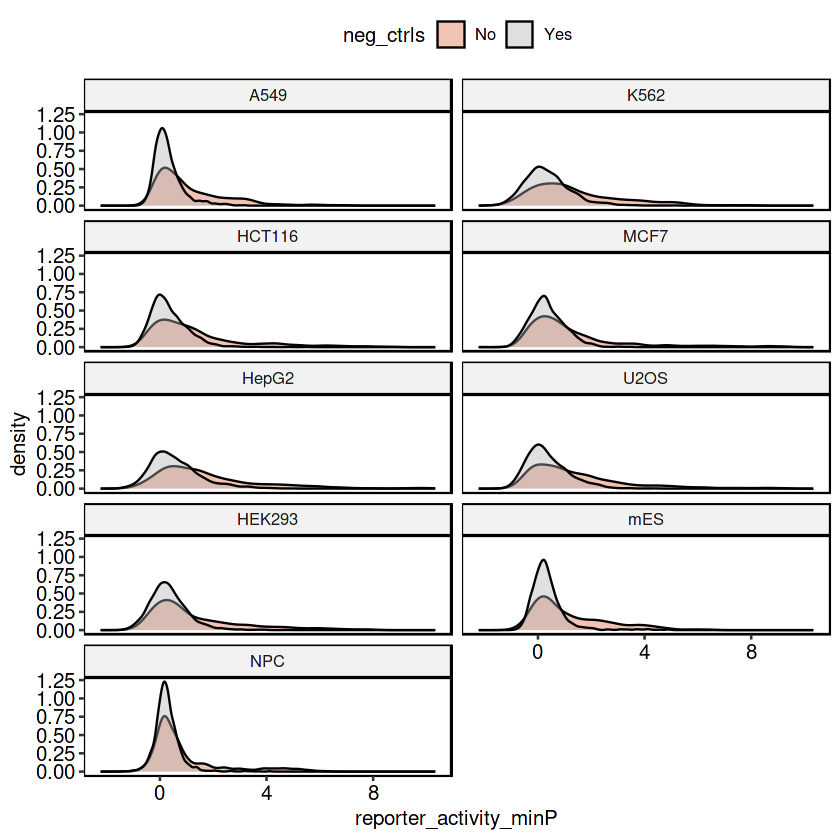

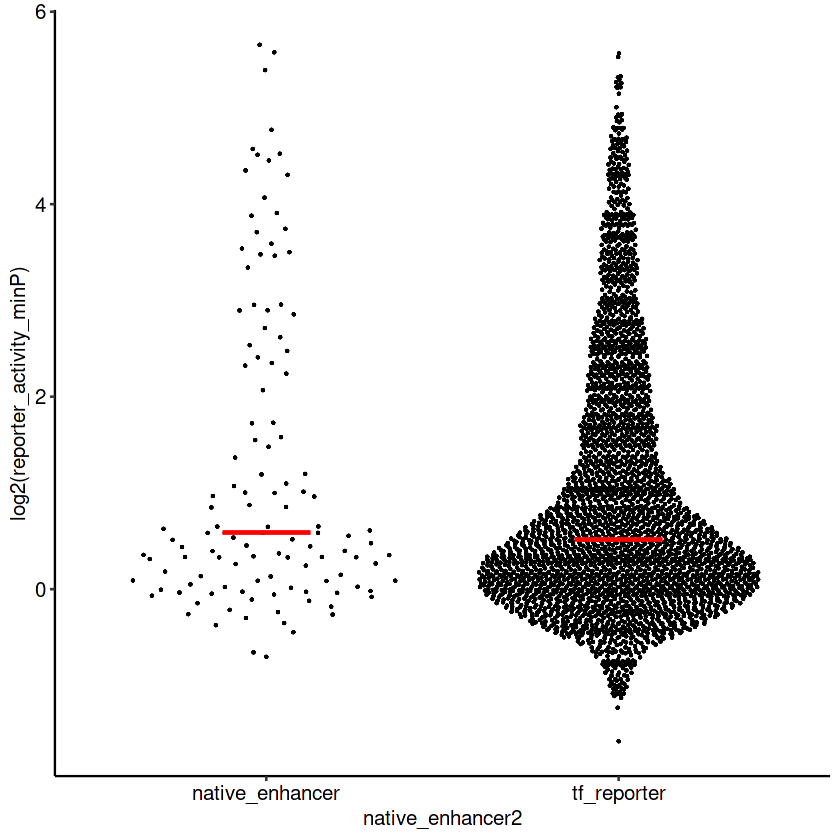

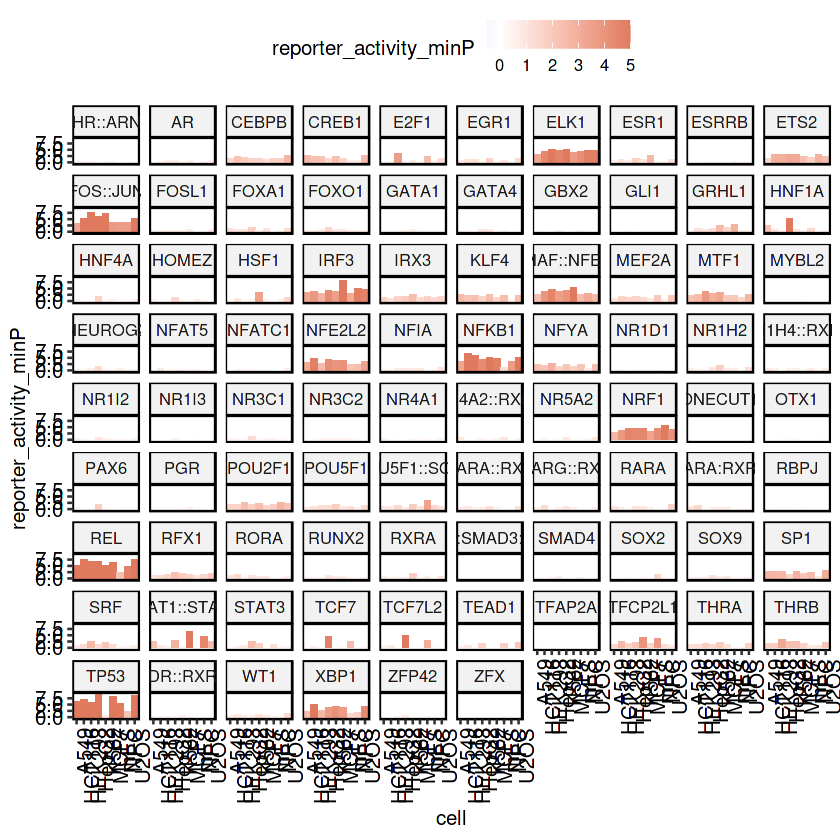

In [5]:
cDNA_df2 <- cDNA_df %>%
  filter(stimulation == "no",
         commercial_reporter == "No", 
         hPGK == "No", 
         str_detect(tf, "RANDOM", negate = T), 
         native_enhancer == "No") %>%
  distinct(tf, reporter_activity_minP, cell, reporter_id, neg_ctrls) %>%
  mutate(reporter_activity_minP = ave(reporter_activity_minP, cell, reporter_id, FUN = mean)) %>%
  mutate(reporter_activity_minP = log2(reporter_activity_minP)) %>%
  distinct() 

ggplot(cDNA_df2 %>%
         mutate(cell = factor(cell, levels = c("A549", "K562", "HCT116", "MCF7", "HepG2", 
                                               "U2OS", "HEK293", "mES", "NPC", "NIH3T3"))),
       aes(x = reporter_activity_minP, fill = neg_ctrls)) +
  geom_density(alpha = .4) +
  facet_wrap(~cell, ncol = 2) +
  scale_fill_manual(values = c("Yes" = "grey70", "No" = "#DD6B48")) +
  theme_pubr(border = T)


## Figure S1G: Compare TF reporters to native enhancer controls
native_activities <- cDNA_df %>%
  filter(condition == "mES_2i_LIF", neg_ctrls == "No") %>%
  distinct(reporter_id, tf, reporter_activity_minP, condition) %>%
  mutate(tf = gsub("_.*", "", tf)) %>%
  mutate(native_enhancer = ifelse(tf %in% c("e97", "e6", "e19", "e11", "e93"), tf, "tf_reporter")) %>%
  mutate(native_enhancer2 = ifelse(native_enhancer == "tf_reporter", native_enhancer, "native_enhancer"))

ggplot(native_activities,
       aes(x = native_enhancer2, y = log2(reporter_activity_minP))) +
  geom_quasirandom_rast(raster.dpi = 600, color = "black", size = .5) +
  stat_summary(fun = median, fun.min = median, fun.max = median, geom = "crossbar", color = "red", width = 0.25, lwd = 0.4) +
  theme_pubr()

## Figure S2A: Median TF activities in all 9 cell types
tf_activities_median <- cDNA_df %>%
  filter(stimulation == "no",
         neg_ctrls == "No",
         commercial_reporter == "No", 
         hPGK == "No", 
         str_detect(tf, "RANDOM", negate = T), 
         native_enhancer == "No") %>%
  distinct(tf, reporter_activity_minP, cell, neg_ctrls) %>%
  mutate(reporter_activity_minP = ave(reporter_activity_minP, cell, tf, FUN = median)) %>%
  mutate(reporter_activity_minP = log2(reporter_activity_minP)) %>%
  distinct(reporter_activity_minP, tf, cell)

ggplot(tf_activities_median,
       aes(x = cell, y = reporter_activity_minP, fill = reporter_activity_minP)) +
  geom_bar(stat = "identity") +
  facet_wrap(~tf) +
  scale_fill_gradient2(low = "#99B2DD", mid = "white", high = "#E07A5F", midpoint = 0, limits = c(-0.5,5), oob = squish) +
  theme_pubr(x.text.angle = 90, border = T)

## Per individual reporter
# tf_reporter_activities_median <- cDNA_df %>%
#   filter(stimulation == "no",
#          neg_ctrls == "No",
#          commercial_reporter == "No", 
#          hPGK == "No", 
#          str_detect(tf, "RANDOM", negate = T), 
#          native_enhancer == "No") %>%
#   distinct(tf, reporter_activity_minP, reporter_id, cell) %>%
#   mutate(reporter_activity_minP = ave(reporter_activity_minP, reporter_id, cell, tf, FUN = median)) %>%
#   mutate(reporter_activity_minP = log2(reporter_activity_minP)) %>%
#   distinct(reporter_activity_minP, tf, reporter_id, cell)
# 
# ggplot(tf_reporter_activities_median,
#        aes(x = cell, y = reporter_activity_minP)) +
#   geom_boxplot() +
#   facet_wrap(~tf) +
#   theme_pubr(x.text.angle = 90, border = T)

In [ ]:
fc_df <- cDNA_df %>%
  filter(stimulation != "no", neg_ctrls == "No", native_enhancer == "No", hPGK == "No") %>%
  mutate(tf = gsub("_.*", "", tf)) %>%
  distinct(reporter_id, tf, reporter_dif_minP, condition, tf_target) %>%
  mutate(mean_dif = ave(reporter_dif_minP, tf, condition, FUN = function(x) mean(x, na.rm = T))) %>%
  mutate(tf_length = ave(tf, tf, FUN = length)) %>%
  filter(tf_length > 10)

# for (i in unique(fc_df$tf)) {
#   p <- ggplot(fc_df %>% filter(tf == i),
#          aes(x = reorder(condition, -mean_dif), y = reporter_dif_minP, color = as.character(tf_target))) +
#     geom_hline(yintercept = 0, lty = 2) +
#     geom_hline(yintercept = 1) +
#     geom_hline(yintercept = -1) +
#     geom_point() +
#     scale_color_manual(values = c("0" = "black", "1" = "red", "2" = "blue")) +
#     theme_pubr(x.text.angle = 90) +
#     ggtitle(i)
# 
#   print(p)
# }
# 
# for (i in unique(fc_df$condition)) {
#   p <- ggplot(fc_df %>% filter(condition == i),
#          aes(x = reorder(tf, -mean_dif), y = reporter_dif_minP, color = as.character(tf_target))) +
#     geom_hline(yintercept = 0, lty = 2) +
#     geom_hline(yintercept = 1) +
#     geom_hline(yintercept = -1) +
#     geom_point() +
#     scale_color_manual(values = c("0" = "black", "1" = "red", "2" = "blue")) +
#     theme_pubr(x.text.angle = 90) +
#     ggtitle(i)
# 
#   print(p)
# }